In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 15})

from pandas_datareader.data import DataReader

from datetime import datetime
import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from math import *

import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set start and end time for data grab
end = '2023-12-15'
start = '2022-11-30'

NVDA = yf.download('NVDA',  start, end)
SO = yf.download('SO', start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'SO Closing Price - First Difference')

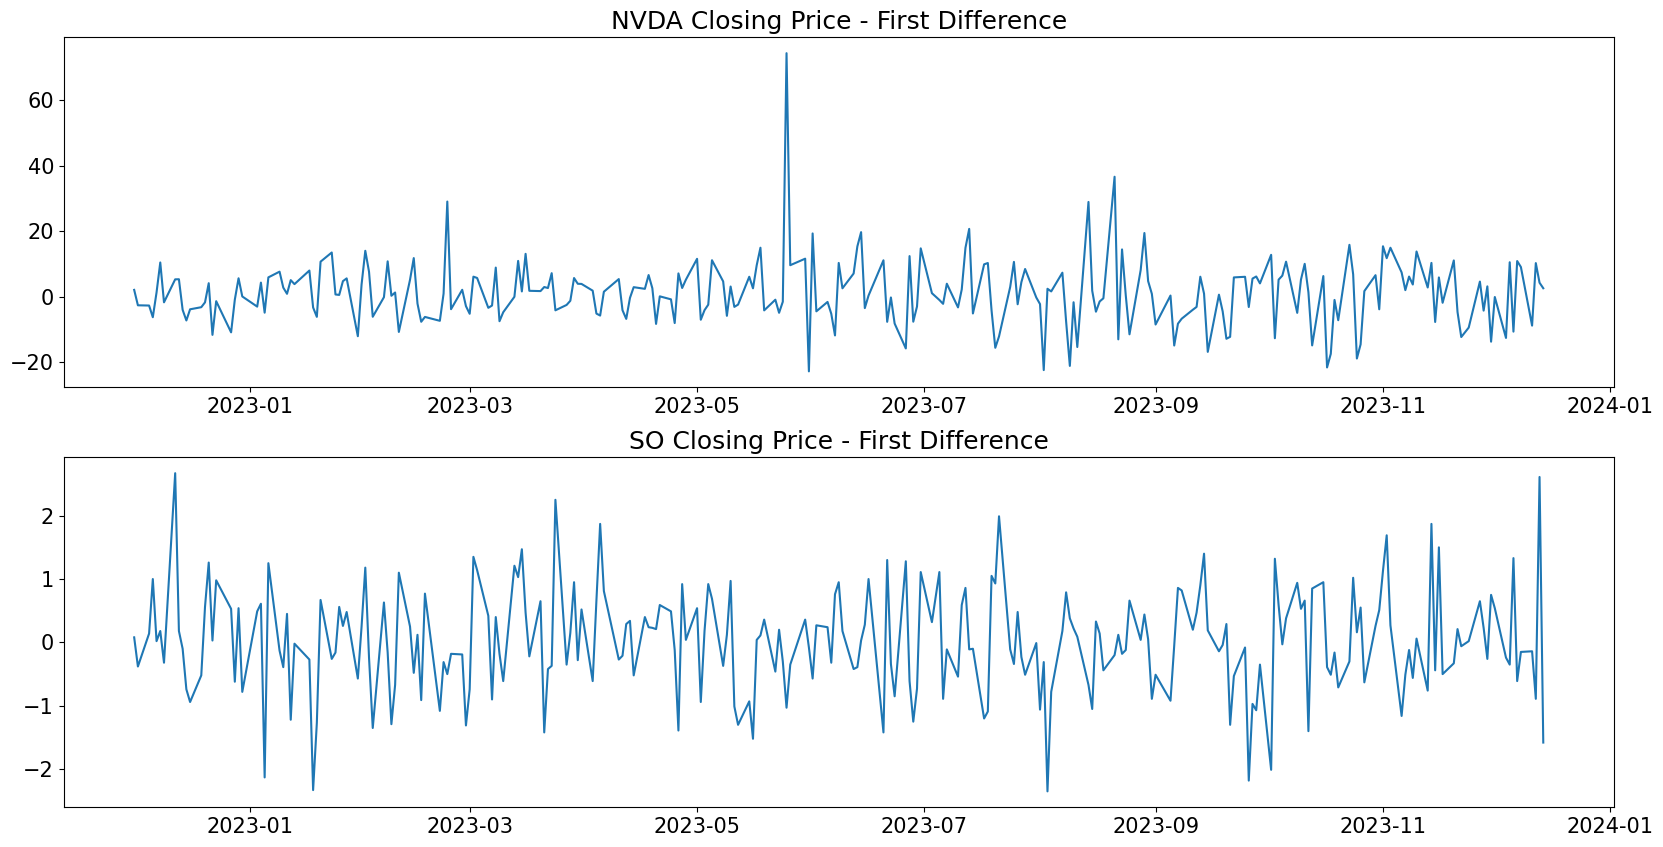

In [3]:
NVDA = NVDA['Close']
SO = SO['Close']
NVDA_diff = NVDA.diff().dropna()
SO_diff = SO.diff().dropna()

plt.figure(figsize=(20,10))

# NVDA plot
plt.subplot(2, 1, 1)
plt.plot(NVDA_diff)
plt.title('NVDA Closing Price - First Difference')

# SO plot
plt.subplot(2, 1, 2)
plt.plot(SO_diff)
plt.title('SO Closing Price - First Difference')

## Dickey-Fuller Test

In [4]:
# Perform Dickey-Fuller test
NVDA_result = adfuller(NVDA)
print('ADF Statistic: %f' % NVDA_result[0])
print('p-value: %f' % NVDA_result[1])
for key, value in NVDA_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.989783
p-value: 0.756972
	1%: -3.456
	5%: -2.873
	10%: -2.573


fail to reject null, non stationary

In [5]:
NVDA_result = adfuller(NVDA_diff)
print('ADF Statistic: %f' % NVDA_result[0])
print('p-value: %f' % NVDA_result[1])
for key, value in NVDA_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.816834
p-value: 0.000000
	1%: -3.456
	5%: -2.873
	10%: -2.573


NVDA's first order difference is stationary

In [6]:
SO_result = adfuller(SO)
print('ADF Statistic: %f' % SO_result[0])
print('p-value: %f' % SO_result[1])
for key, value in SO_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.561741
p-value: 0.101165
	1%: -3.456
	5%: -2.873
	10%: -2.573


Not significant enough at 1%

In [7]:
SO_result = adfuller(SO_diff)
print('ADF Statistic: %f' % SO_result[0])
print('p-value: %f' % SO_result[1])
for key, value in SO_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.525033
p-value: 0.000000
	1%: -3.456
	5%: -2.873
	10%: -2.573


Since the p-values are very small and the test statistics are less than the critical values, we have strong evidence to suggest that the first differenced series are stationary for both stocks, thus d = 1. With this confirmed, we can proceed with identifying the ARIMA model parameters (p, d, q) for each stock.

# ACF and PACF Plots

In [9]:



def plot_diagnostics(data, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_ylabel('ACF', fontsize=15)
    axes[0].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(data,lags=40,zero=True, ax = axes[0], title= 'ACF of '+ title, use_vlines = True)
    axes[1].set_ylabel('ACF', fontsize=15)
    axes[1].set_xlabel('Lag', fontsize=15)
    fig = plot_pacf(data,lags=40,zero=True, ax = axes[1], title= 'PACF of '+ title, use_vlines = True)
    plt.savefig("ACF2.png", dpi = 300)

    plt.tight_layout()
    plt.show()


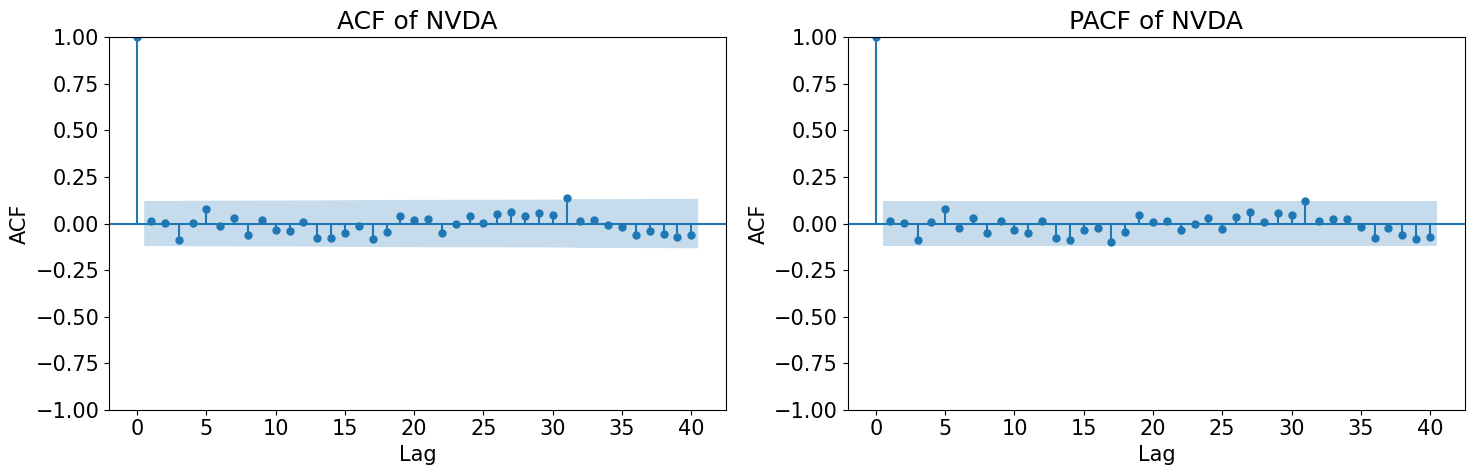

In [10]:
plot_diagnostics(NVDA_diff, title='NVDA')

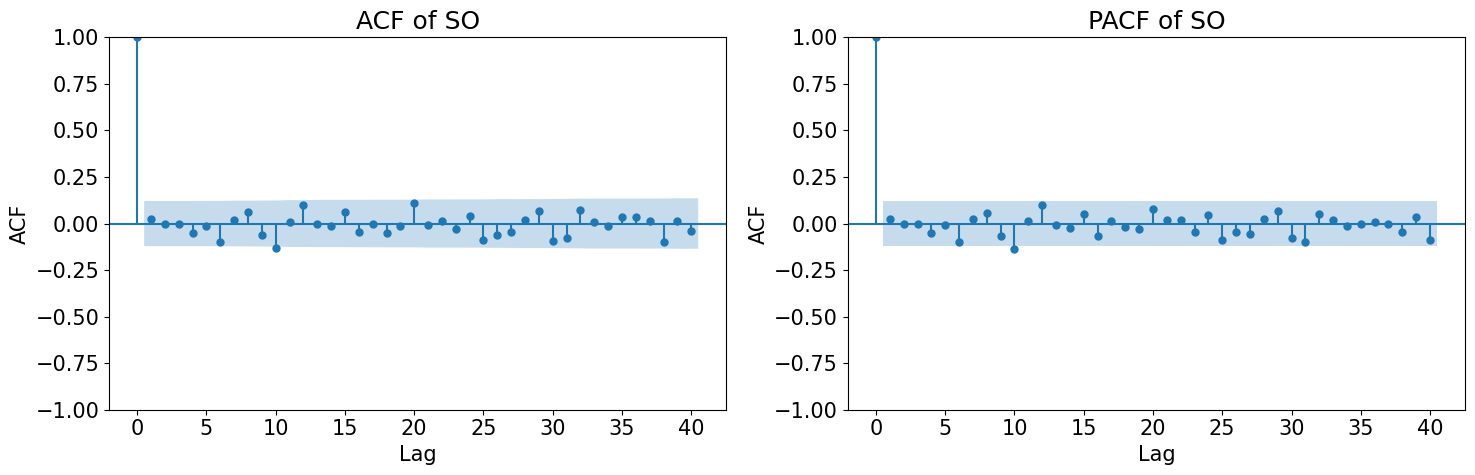

In [11]:
plot_diagnostics(SO_diff, title='SO')

For NVDA: \
The PACF drops off after lag 1, suggesting a possible AR(1) component, so p=1 is considereable. \
The ACF shows significance at multiple lags, but since we have already differentiated the series and the PACF cuts off after the first lag, it suggests a possible MA(1)\ component, so q=1. \
For SO: \
The PACF drops off after lag 1, suggesting a possible AR(1) component, so p=1. \
The ACF plot also tails off after the first lag, which would suggest an MA(1) component, so q=1. \
We can also use searchARMA for further refinement.

In [12]:
# Ignore Data index
NVDA_diff.reset_index(drop=True, inplace=True)
SO_diff.reset_index(drop=True, inplace=True)
NVDA.reset_index(drop=True, inplace=True)
SO.reset_index(drop=True, inplace=True)


# NVDA

## Training

In [13]:
# Train Test Split
train_size_NVDA = int(len(NVDA) * 0.8)
train_NVDA, test_NVDA = NVDA[:train_size_NVDA], NVDA[train_size_NVDA:]


## Find Optimal p and q

In [14]:

def searchARMA(data, exog, max_p, max_q):
    aic = np.full((max_p, max_q), np.inf)
    bic = np.full((max_p, max_q), np.inf)

    for i in range(max_p):
        for j in range(max_q):
            try:
                if len(exog) == len(data):
                    model = ARIMA(data, order=(i, 0, j), exog=exog, trend='n')
                else:
                    model = ARIMA(data, order=(i, 0, j), trend='n')
                res = model.fit()
                aic[i, j] = res.aic
                bic[i, j] = res.bic
                print('p:', i, ' q:', j, ' aic:', aic[i, j], ' bic:', bic[i, j])
            except Exception as e:
                print('p:', i, ' q:', j, 'Exception:', e)
                continue


In [15]:
n1 = len(NVDA_diff)
n2 = len(SO_diff)
exog1 = np.ones(n1)
exog2 = np.ones(n2)

searchARMA(NVDA_diff, exog1, max_p=6, max_q=3)

p: 0  q: 0  aic: 1944.5257669509247  bic: 1951.65480776557
p: 0  q: 1  aic: 1946.4645255702844  bic: 1957.1580867922526
p: 0  q: 2  aic: 1948.4607571978388  bic: 1962.7188388271295
p: 1  q: 0  aic: 1946.4642493164538  bic: 1957.157810538422
p: 1  q: 1  aic: 1948.4642384859144  bic: 1962.722320115205
p: 1  q: 2  aic: 1950.139869468344  bic: 1967.9624715049574
p: 2  q: 0  aic: 1948.4640928259773  bic: 1962.722174455268
p: 2  q: 1  aic: 1950.229994564557  bic: 1968.0525966011705
p: 2  q: 2  aic: 1946.5313827502225  bic: 1967.9185051941586
p: 3  q: 0  aic: 1948.3672684152712  bic: 1966.1898704518846
p: 3  q: 1  aic: 1950.3623420475972  bic: 1971.7494644915332
p: 3  q: 2  aic: 1948.3664001298953  bic: 1973.3180429811541
p: 4  q: 0  aic: 1950.3537798047005  bic: 1971.7409022486368
p: 4  q: 1  aic: 1952.050983412501  bic: 1977.0026262637598
p: 4  q: 2  aic: 1950.6731009654336  bic: 1979.1892642240152
p: 5  q: 0  aic: 1950.8066095931924  bic: 1975.7582524444513
p: 5  q: 1  aic: 1952.1518748804

In [16]:
# from searchARMA
orders = [(0, 0), (0, 2), (2, 2)]

rmse_dict = {}

for order in orders:
    try:
        # Fit model
        model = ARIMA(train_NVDA, order=(order[0], 1, order[1]), trend='n')
        model_fit = model.fit()

        # Make predictions
        predictions = model_fit.forecast(steps=len(test_NVDA))
        rmse = sqrt(mean_squared_error(test_NVDA, predictions))
        rmse_dict[order] = rmse
        print(f"Order {order}: RMSE = {rmse}")
    except Exception as e:
        print(f"Error with order {order}: {e}")

best_order = min(rmse_dict, key=rmse_dict.get)
print(f"Best model order is {best_order} with RMSE = {rmse_dict[best_order]}")

Order (0, 0): RMSE = 35.00745317511409
Order (0, 2): RMSE = 35.028587125199145
Order (2, 2): RMSE = 35.056676257601296
Best model order is (0, 0) with RMSE = 35.00745317511409


In [17]:
model_NVDA = ARIMA(train_NVDA, order=(0,1,0))
model_fit_NVDA = model_NVDA.fit()
NVDA_result = model_NVDA.fit()
print(NVDA_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  209
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -775.378
Date:                Wed, 01 May 2024   AIC                           1552.755
Time:                        16:18:13   BIC                           1556.093
Sample:                             0   HQIC                          1554.105
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       101.2667      3.500     28.930      0.000      94.406     108.127
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1730.27
Prob(Q):                              0.88   Pr

In [18]:

def plot_diagnosticsTight3(data):

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))

    ax1.hist(data, bins =40,color='m', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Resid")

    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Resid")

    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
    ax3.grid()


    fig = sm.qqplot(data, line='q', ax = ax4)
    ax4.grid()


    plt.tight_layout()

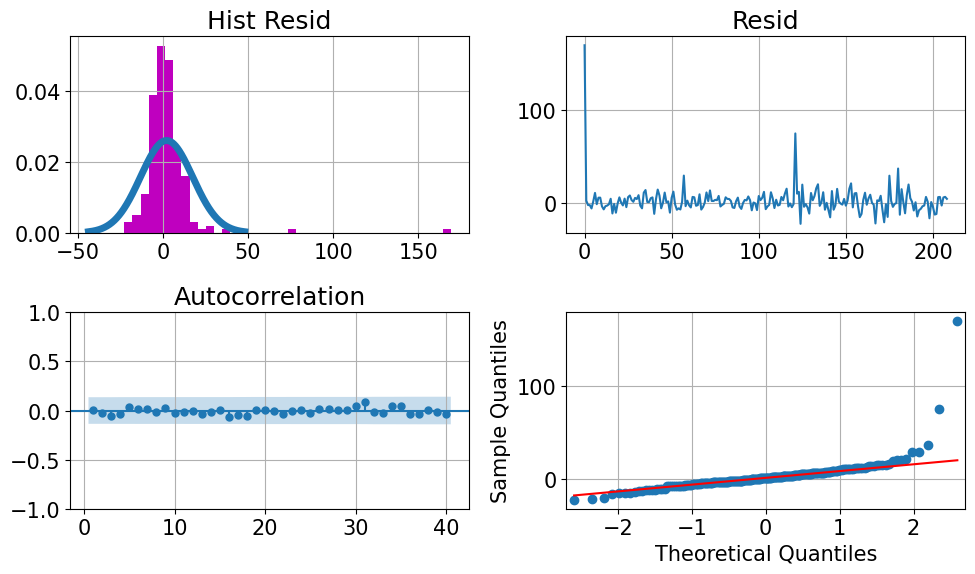

In [19]:
resid = NVDA_result.resid
plot_diagnosticsTight3(resid)

## Forecast

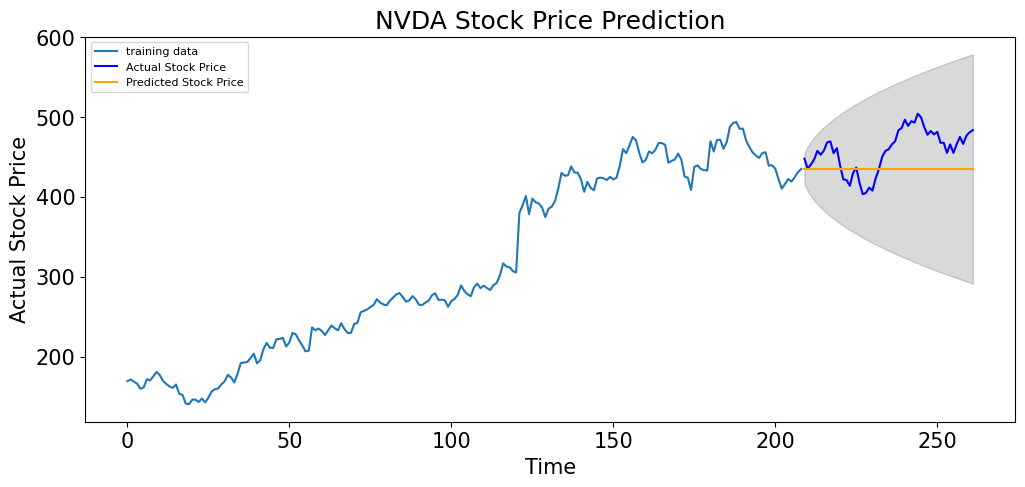

In [20]:
# Ref: https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting#9.-How-to-build-the-ARIMA-Model-

# Forecast
step = len(test_NVDA)
NVDA_fc = NVDA_result.get_forecast(steps=step)
forecast = NVDA_fc.predicted_mean
conf_int = NVDA_fc.conf_int(alpha=0.05) # 95%

fc_series = pd.Series(forecast, index=test_NVDA.index)

# Lower and upper bounds for the conf int
NVDA_lower_series = pd.Series(conf_int.iloc[:, 0], index=test_NVDA.index)
NVDA_upper_series = pd.Series(conf_int.iloc[:, 1], index=test_NVDA.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_NVDA, label='training data')
plt.plot(test_NVDA, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(NVDA_lower_series.index, NVDA_lower_series, NVDA_upper_series, color='k', alpha=.15)

plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

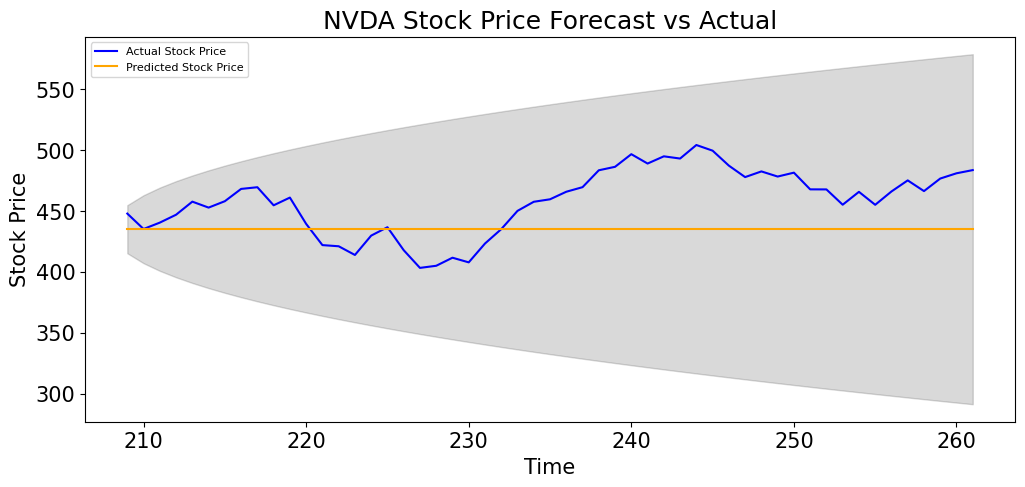

In [21]:
# Closer look
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(test_NVDA, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(NVDA_lower_series.index, NVDA_lower_series, NVDA_upper_series, color='k', alpha=.15)

plt.title('NVDA Stock Price Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()



In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
NVDA_fc_result = NVDA_result.forecast(step)

mae = mean_absolute_error(test_NVDA, NVDA_fc_result)
mse = mean_squared_error(test_NVDA, NVDA_fc_result)
rmse = np.sqrt(mse)  # Or use mean_squared_error(test_NVDA, NVDA_fc, squared=False)
mape = np.mean(np.abs(test_NVDA - NVDA_fc_result) / test_NVDA) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')


MAE: 30.335102009323407
MSE: 1225.5217778078052
RMSE: 35.00745317511409
MAPE: 6.477476686008882%


# SO

In [23]:
# Train Test Split
train_size_SO = int(len(SO) * 0.8)
train_SO, test_SO = SO[:train_size_SO], SO[train_size_SO:]

In [24]:
searchARMA(SO_diff, exog2, max_p=6, max_q=3)

p: 0  q: 0  aic: 644.27270760883  bic: 651.4017484234754
p: 0  q: 1  aic: 646.0880857973552  bic: 656.7816470193234
p: 0  q: 2  aic: 648.0873475655771  bic: 662.345429194868
p: 1  q: 0  aic: 646.0887796736702  bic: 656.7823408956383
p: 1  q: 1  aic: 648.087170373859  bic: 662.3452520031498
p: 1  q: 2  aic: 645.3804649873906  bic: 663.2030670240041
p: 2  q: 0  aic: 648.0874605742936  bic: 662.3455422035844
p: 2  q: 1  aic: 645.3524110366947  bic: 663.1750130733082
p: 2  q: 2  aic: 646.5441110397858  bic: 667.9312334837219
p: 3  q: 0  aic: 650.0871479825241  bic: 667.9097500191376
p: 3  q: 1  aic: 652.0874111394767  bic: 673.4745335834128
p: 3  q: 2  aic: 648.1053498119259  bic: 673.0569926631847
p: 4  q: 0  aic: 651.4475328810921  bic: 672.8346553250283
p: 4  q: 1  aic: 652.6023754859502  bic: 677.5540183372091
p: 4  q: 2  aic: 650.064590747321  bic: 678.5807540059025
p: 5  q: 0  aic: 653.431793409903  bic: 678.3834362611618
p: 5  q: 1  aic: 650.9130065952922  bic: 679.4291698538738
p: 

In [25]:
# from searchARMA
orders = [(0, 0), (0, 1), (1, 0), (2, 1), (2,0), (2, 2)]

# Initialize a dictionary to store MSE for each model
rmse_dict = {}

for order in orders:
    try:
        # Fit model
        model = ARIMA(train_SO, order=(order[0], 1, order[1]), trend='n')
        model_fit = model.fit()

        # Make predictions
        predictions = model_fit.forecast(steps=len(test_SO))

        # Calculate RMSE
        rmse = sqrt(mean_squared_error(test_SO, predictions))
        rmse_dict[order] = rmse
        print(f"Order {order}: MSE = {rmse}")
    except Exception as e:
        print(f"Error with order {order}: {e}")

best_order = min(rmse_dict, key=rmse_dict.get)
print(f"Best model order is {best_order} with RMSE = {rmse_dict[best_order]}")

Order (0, 0): MSE = 4.376675832133107
Order (0, 1): MSE = 4.39862106843018
Order (1, 0): MSE = 4.4097492216108645
Order (2, 1): MSE = 4.364852671332113
Order (2, 0): MSE = 4.3701780839766995
Order (2, 2): MSE = 1.8964533488240372
Best model order is (2, 2) with RMSE = 1.8964533488240372


In [26]:
model_SO = ARIMA(train_SO, order=(2,1,2))
model_fit_SO = model_SO.fit()
SO_result = model_SO.fit()
print(SO_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  209
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -248.265
Date:                Wed, 01 May 2024   AIC                            506.529
Time:                        16:18:41   BIC                            523.217
Sample:                             0   HQIC                           513.277
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3429      0.289      1.185      0.236      -0.224       0.910
ar.L2          0.5919      0.283      2.092      0.036       0.037       1.146
ma.L1         -0.2772      0.676     -0.410      0.6

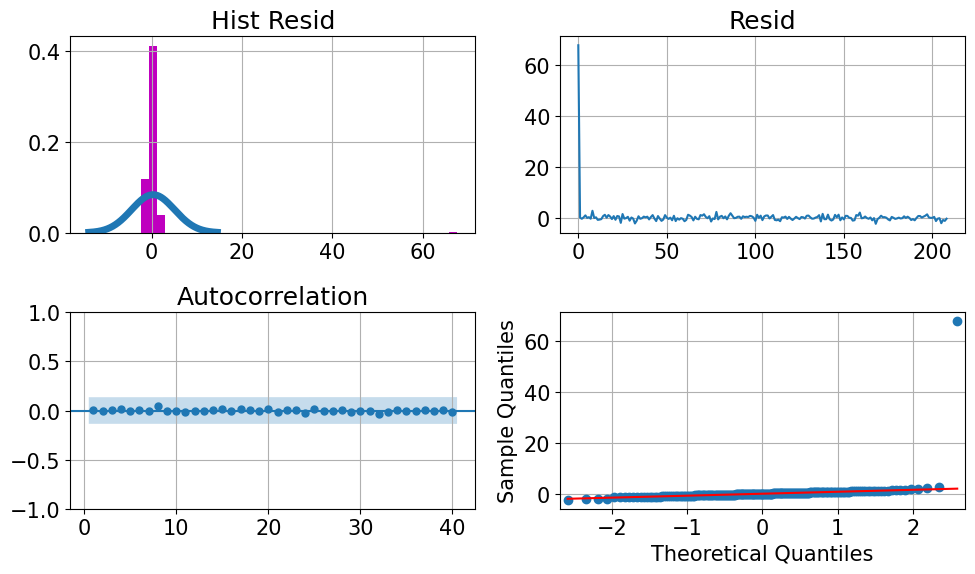

In [27]:
resid = SO_result.resid
plot_diagnosticsTight3(resid)

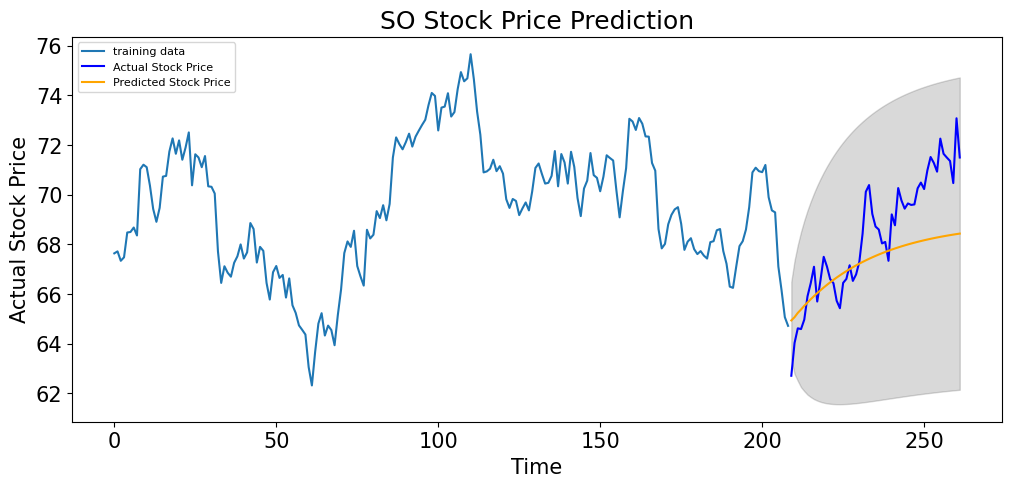

In [28]:
# Ref: https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting#9.-How-to-build-the-ARIMA-Model-

# Forecast
step = len(test_SO)
SO_fc = SO_result.get_forecast(steps=step)
forecast = SO_fc.predicted_mean
conf_int = SO_fc.conf_int(alpha=0.05) # 95%

fc_series = pd.Series(forecast, index=test_SO.index)

# Lower and upper bounds for the conf int
SO_lower_series = pd.Series(conf_int.iloc[:, 0], index=test_SO.index)
SO_upper_series = pd.Series(conf_int.iloc[:, 1], index=test_SO.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_SO, label='training data')
plt.plot(test_SO, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(SO_lower_series.index, SO_lower_series, SO_upper_series, color='k', alpha=.15)

plt.title('SO Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()



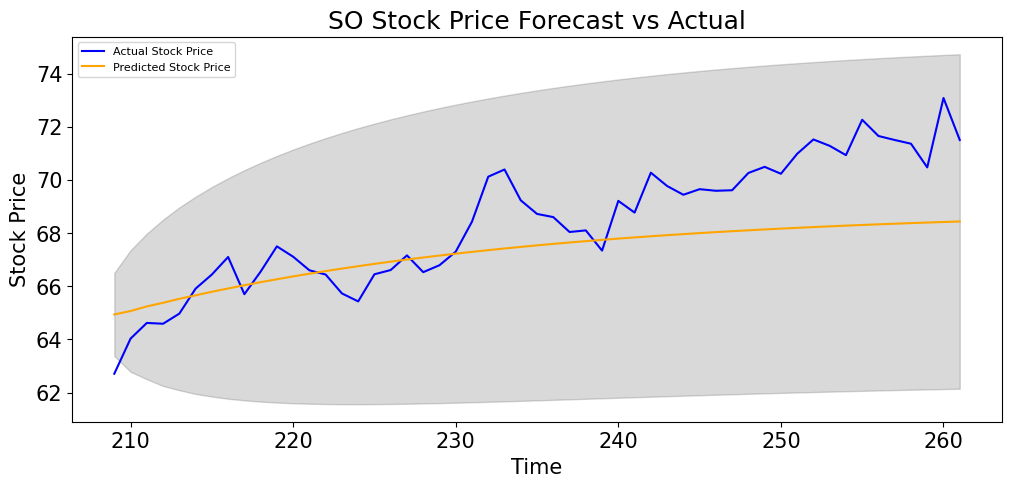

In [29]:
# Closer look
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(test_SO, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(SO_lower_series.index, SO_lower_series, SO_upper_series, color='k', alpha=.15)

plt.title('SO Stock Price Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [30]:
SO_fc_result = SO_result.forecast(step)
mae = mean_absolute_error(test_SO, SO_fc_result)
mse = mean_squared_error(test_SO, SO_fc_result)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(test_SO - SO_fc_result) / test_SO) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

MAE: 1.5240567389469515
MSE: 3.596535304265905
RMSE: 1.8964533488240372
MAPE: 2.1865204464255426%
